In [2]:
! pip install opendatasets

In [9]:
import os
import opendatasets as od
import numpy as np # for data manipulation
import pandas as pd # for data manipulation
import random # for data visualization
import matplotlib.pyplot as plt # for data visualization
import time

import cv2
from skimage.feature import hog, local_binary_pattern, graycomatrix, graycoprops
from skimage.measure import moments_hu, shannon_entropy, label as skimage_label, regionprops
from skimage.morphology import skeletonize
from skimage.color import rgb2gray
from skimage import img_as_ubyte, exposure
from scipy.stats import skew, kurtosis

In [4]:
od.download('https://www.kaggle.com/datasets/ardamavi/27-class-sign-language-dataset/data')

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: sebastianspratz
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/ardamavi/27-class-sign-language-dataset


100%|██████████| 1.06G/1.06G [00:54<00:00, 20.7MB/s]


In [5]:
X = np.load('27-class-sign-language-dataset/X.npy')
y = np.load('27-class-sign-language-dataset/Y.npy')

In [6]:
print(f"Original shapes: X: {X.shape}, y: {y.shape}")

Original shapes: X: (22801, 128, 128, 3), y: (22801, 1)


In [13]:
# due to computational constraints:
max_samples_per_category = 50
unique_labels = np.unique(y)
# Create a list to store the selected images and labels
X_selected = []
y_selected = []

# Randomly select up to 50 images per category
for label in unique_labels:
    # Get indices of all images with the current label
    indices = np.where(y == label)[0]

    # Randomly sample up to 50 indices for the current label
    if len(indices) > max_samples_per_category:
        selected_indices = random.sample(list(indices), max_samples_per_category)
    else:
        selected_indices = indices  # Use all images if less than 50

    # Append the selected images and labels to the lists
    X_selected.extend(X[selected_indices])
    y_selected.extend(y[selected_indices])

# Convert lists to numpy arrays
X_selected = np.array(X_selected)
y_selected = np.array(y_selected)

print(f"Selected dataset shape: X_selected: {X_selected.shape}, y_selected: {y_selected.shape}")

Selected dataset shape: X_selected: (1350, 128, 128, 3), y_selected: (1350, 1)


In [8]:
def extract_features(image):
    features = {}

    # Convert to grayscale if the image is in color
    if len(image.shape) == 3:
        image = rgb2gray(image)

    # 1. Hu Moments
    hu_moments = moments_hu(image)
    for i, moment in enumerate(hu_moments):
        features[f'hu_moment_{i}'] = moment

    # 2. HOG Features
    hog_features = hog(image, pixels_per_cell=(16, 16), cells_per_block=(1, 1), channel_axis=None)
    hog_features = hog_features.flatten()
    for i, feature in enumerate(hog_features):
        features[f'hog_{i}'] = feature

    # 3. Local Binary Patterns (LBP)
    lbp = local_binary_pattern(image, P=8, R=1, method='uniform')
    lbp_hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, 60), density=True)  # 59 bins for uniform LBP
    for i, hist_value in enumerate(lbp_hist):
        features[f'lbp_hist_{i}'] = hist_value

    contours, _ = cv2.findContours(img_as_ubyte(image), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if contours:
        cnt = max(contours, key=cv2.contourArea)

    # 4. Geometric Shape Features (Contour-based)
    if contours:
        area = cv2.contourArea(cnt)
        perimeter = cv2.arcLength(cnt, True)
        x, y, w, h = cv2.boundingRect(cnt)
        aspect_ratio = float(w) / h
        extent = area / (w * h)
        hull = cv2.convexHull(cnt)
        hull_area = cv2.contourArea(hull)
        solidity = float(area) / hull_area
        features.update({
            'area': area,
            'perimeter': perimeter,
            'aspect_ratio': aspect_ratio,
            'extent': extent,
            'solidity': solidity
        })

    # 5. Haralick Texture Features (GLCM)
    glcm = graycomatrix(img_as_ubyte(image), distances=[1], angles=[0, np.pi/4, np.pi/2, 3*np.pi/4], symmetric=True, normed=True)
    features['contrast'] = graycoprops(glcm, 'contrast').mean()
    features['dissimilarity'] = graycoprops(glcm, 'dissimilarity').mean()
    features['homogeneity'] = graycoprops(glcm, 'homogeneity').mean()
    features['energy'] = graycoprops(glcm, 'energy').mean()
    features['correlation'] = graycoprops(glcm, 'correlation').mean()

    # 6. Skeletonization and Finger Count
    skeleton = skeletonize(image > 0.8)
    labeled_skeleton = skimage_label(skeleton)
    features['num_fingers'] = len(regionprops(labeled_skeleton))  # Rough count of fingers as separate regions

    # 7. Convex Hull Defects
    if contours:
        hull_points = cv2.convexHull(cnt, returnPoints=False)
        defects = cv2.convexityDefects(cnt, hull_points)
        features['num_defects'] = len(defects) if defects is not None else 0

    # 8. Statistical Pixel Intensity Features
    pixel_values = image.ravel()
    features['mean_intensity'] = np.mean(pixel_values)
    features['intensity_variance'] = np.var(pixel_values)
    features['intensity_skewness'] = skew(pixel_values)
    features['intensity_kurtosis'] = kurtosis(pixel_values)
    features['entropy'] = shannon_entropy(image)

    return features

In [14]:
ini_time = time.time()
# Initialize an empty list to hold all the feature vectors
all_features = []

# Iterate through each image in X and extract its features
print(len(X_selected))
for i, image in enumerate(X_selected):
    # Extract features for the current image
    features = extract_features(image)

    # Append the label to the features
    features['label'] = y_selected[i][0]

    # Append the feature dictionary to the list
    all_features.append(features)

    if i % 50 == 0:
        print(np.round(i / len(X_selected), 2))

end_time = time.time()

total_time = np.round((end_time - ini_time) / 60, 2)
print(f'It took a total of : {total_time} [min]')
# Convert the list of feature dictionaries into a DataFrame
df = pd.DataFrame(all_features)

1350
0.0
0.02
0.04
0.05
It took a total of : 1.12 [min]


In [17]:
print(f'Amount of features: {df.shape[1]}')
print(f'Amount of images: {df.shape[0]}')

Amount of features: 660
Amount of images: 1350


In [18]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score
from scipy.stats import randint

In [19]:
y_model = df['label']  # Labels (target column)
X_model = df.drop('label', axis=1)  # Features (drop the 'label' column)

# Label encoding for the target labels
label_encoder = LabelEncoder()
y_model_encoded = label_encoder.fit_transform(y_model)

# Split the data into train and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X_model, y_model_encoded, test_size=0.2, random_state=42)

In [20]:
# Initialize the Random Forest Classifier
rf_classifier_HOG = RandomForestClassifier(n_estimators=400, max_depth=40, max_features='sqrt',random_state=42)

# Train the Random Forest Classifier on the training data
rf_classifier_HOG.fit(X_train, y_train)

# Make predictions on the test data
y_pred = rf_classifier_HOG.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Classification report (precision, recall, f1-score)
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Optionally, decode the predictions back to original labels if needed
y_pred_labels = label_encoder.inverse_transform(y_pred)

Accuracy: 0.4444
Classification Report:
              precision    recall  f1-score   support

           0       0.27      0.38      0.32         8
           1       0.43      0.50      0.46        12
           2       0.17      0.17      0.17         6
           3       0.62      0.56      0.59         9
           4       0.62      0.38      0.48        13
           5       0.33      0.40      0.36        10
           6       0.06      0.11      0.08         9
           7       0.38      0.23      0.29        13
           8       0.75      0.27      0.40        11
           9       0.23      0.38      0.29         8
          10       0.40      0.25      0.31         8
          11       0.50      0.62      0.55        13
          12       0.20      0.25      0.22         8
          13       0.42      0.62      0.50         8
          14       0.58      0.64      0.61        11
          15       0.67      0.67      0.67         9
          16       0.40      0.40      0.

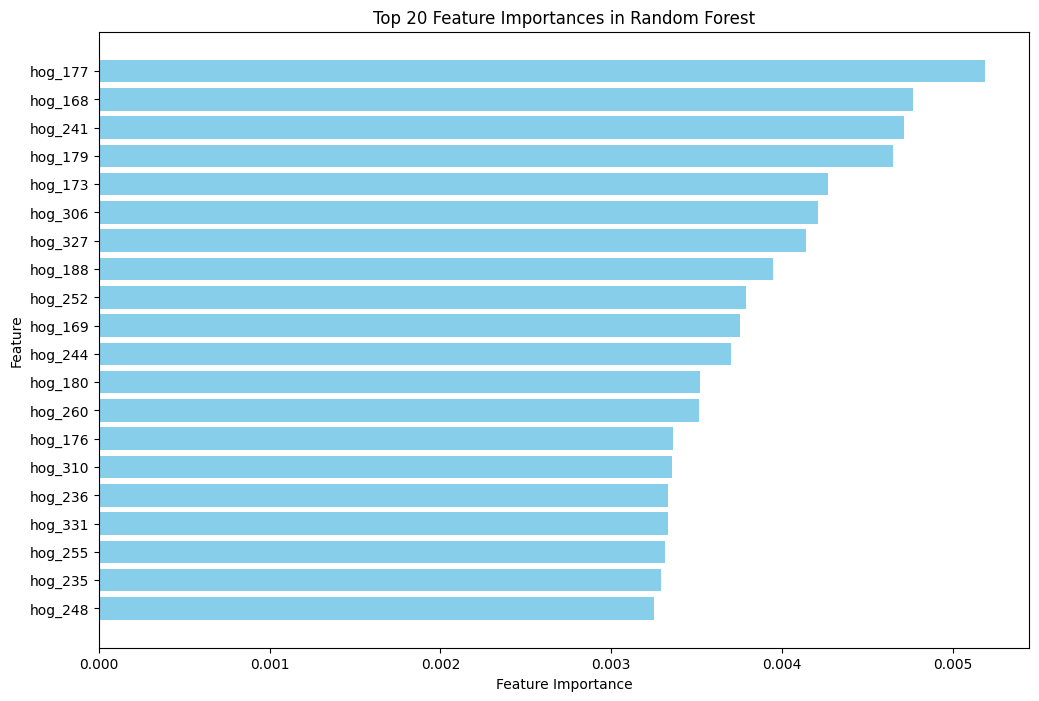

In [50]:
# Get feature importances
importances = rf_classifier_HOG.feature_importances_
feature_names = X_model.columns  # Feature names from your DataFrame

# Create a DataFrame for easy sorting
importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})

# Sort by importance (descending order)
importance_df = importance_df.sort_values(by='importance', ascending=False).reset_index(drop=True)

# Select the top N features
N = 20  # Number of top features to display
top_features = importance_df.head(N)

# Plot
plt.figure(figsize=(12, 8))
plt.barh(top_features['feature'], top_features['importance'], color='skyblue')
plt.gca().invert_yaxis()  # Invert y-axis to show the most important feature on top
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title(f'Top {N} Feature Importances in Random Forest')
plt.show()


In [45]:
from skimage.feature import hog
from skimage.color import rgb2gray
import numpy as np
import matplotlib.pyplot as plt

# Parameters
pixels_per_cell = (16, 16)  # Same as in feature extraction
cells_per_block = (1, 1)    # Same as in feature extraction
orientations = 9            # Default number of orientations in HOG


image = X[15]


# Compute HOG
image_gray = rgb2gray(image) if image.ndim == 3 else image
hog_features, hog_image = hog(
    image_gray,
    pixels_per_cell=pixels_per_cell,
    cells_per_block=cells_per_block,
    orientations=orientations,
    visualize=True,
    channel_axis=None
)

# Compute grid dimensions
cell_rows = image_gray.shape[0] // pixels_per_cell[0]
cell_cols = image_gray.shape[1] // pixels_per_cell[1]
hog_grid = hog_features.reshape(cell_rows, cell_cols, orientations)

print(f"HOG grid shape: {hog_grid.shape}")


HOG grid shape: (8, 8, 9)


In [46]:
importances = rf_classifier_HOG.feature_importances_
hog_feature_indices = [i for i, col in enumerate(X_model.columns) if 'hog_' in col]
hog_importances = [importances[i] for i in hog_feature_indices]

amount_of_hof_to_visualize = 35

# Get the top important HOG features
top_hog_indices = sorted(range(len(hog_importances)), key=lambda k: hog_importances[k], reverse=True)[:amount_of_hof_to_visualize]
print(f"Top HOG indices: {top_hog_indices}")

Top HOG indices: [177, 168, 241, 179, 173, 306, 327, 188, 252, 169, 244, 180, 260, 176, 310, 236, 331, 255, 235, 248, 314, 171, 245, 240, 265, 243, 256, 328, 257, 175, 318, 309, 247, 174, 246]


In [47]:
important_cells = []
for index in top_hog_indices:
    flat_cell_index, orientation_bin = divmod(index, 9)  # 9 is the number of orientations
    cell_row, cell_col = divmod(flat_cell_index, 8)     # 8x8 grid
    important_cells.append((cell_row, cell_col, orientation_bin))
print(f"Important cells and bins: {important_cells}")

Important cells and bins: [(2, 3, 6), (2, 2, 6), (3, 2, 7), (2, 3, 8), (2, 3, 2), (4, 2, 0), (4, 4, 3), (2, 4, 8), (3, 4, 0), (2, 2, 7), (3, 3, 1), (2, 4, 0), (3, 4, 8), (2, 3, 5), (4, 2, 4), (3, 2, 2), (4, 4, 7), (3, 4, 3), (3, 2, 1), (3, 3, 5), (4, 2, 8), (2, 3, 0), (3, 3, 2), (3, 2, 6), (3, 5, 4), (3, 3, 0), (3, 4, 4), (4, 4, 4), (3, 4, 5), (2, 3, 4), (4, 3, 3), (4, 2, 3), (3, 3, 4), (2, 3, 3), (3, 3, 3)]


In [48]:
# Create an importance mask for the grid
importance_mask = np.zeros((8, 8))  # Aggregate over orientations
for cell_row, cell_col, _ in important_cells:
    importance_mask[cell_row, cell_col] += 1  # Increment for each important feature

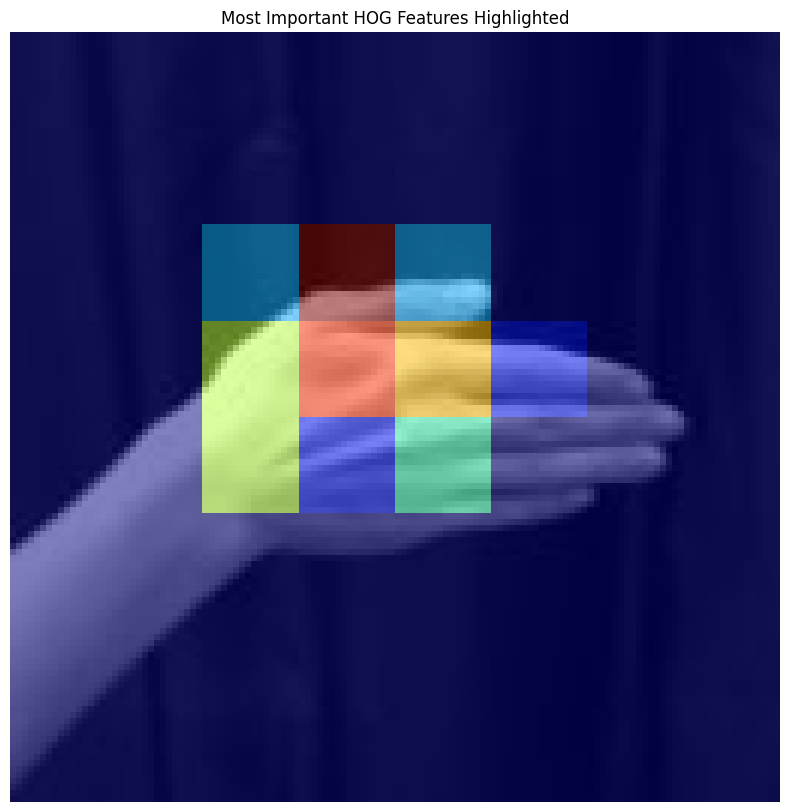

In [49]:
# Upscale the mask to match the image dimensions
upscaled_mask = np.kron(importance_mask, np.ones((16, 16)))  # Each cell corresponds to 16x16 pixels

# Plot the original image with highlighted regions
plt.figure(figsize=(10, 10))
plt.imshow(image_gray, cmap='gray')
plt.imshow(upscaled_mask, alpha=0.5, cmap='jet')  # Overlay the mask
plt.title('Most Important HOG Features Highlighted')
plt.axis('off')
plt.show()
